In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

In [2]:
# Import neccessary libraries
import pyspark as pys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.sql import Row
from pyspark.sql.functions import split

In [3]:
# Setup spark session

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
# Read system log file as csv
pd_df = pd.read_csv('eventlog.csv')
pd_df.head(10)

,Level,Date and Time,Source,Event ID,Task Category,User,Computer,User Time,Event Source Name
Information,20-09-2021 19:25:45,gupdate,0.0,None,NaN,DESKTOP-VU30L9B,NaN,NaN,The operation completed successfully.
Information,20-09-2021 19:10:30,edgeupdate,0.0,None,NaN,DESKTOP-VU30L9B,NaN,NaN,Service stopped.
Information,20-09-2021 18:18:18,Microsoft-Windows-Security-SPP,16384.0,None,NaN,DESKTOP-VU30L9B,NaN,Software Protection Platform Service,Successfully scheduled Software Protection ser...
Information,20-09-2021 18:17:47,Microsoft-Windows-Security-SPP,16394.0,None,NaN,DESKTOP-VU30L9B,NaN,Software Protection Platform Service,Offline downlevel migration succeeded.
Warning,20-09-2021 18:15:15,ESENT,472.0,Logging/Recovery,NaN,DESKTOP-VU30L9B,NaN,NaN,"taskhostw (14060,R,98) WebCacheLocal: The shad..."
Information,20-09-2021 18:15:13,igfxCUIService2.0.0.0,0.0,None,NaN,DESKTOP-VU30L9B,NaN,NaN,The operation completed successfully.
Information,20-09-2021 18:15:12,Microsoft-Windows-Winlogon,6000.0,None,NaN,DESKTOP-VU30L9B,NaN,Wlclntfy,The winlogon notification subscriber <SessionE...
Information,20-09-2021 18:15:09,igfxCUIService2.0.0.0,0.0,None,NaN,DESKTOP-VU30L9B,NaN,NaN,The operation completed successfully.
Information,20-09-2021 18:15:09,igfxCUIService2.0.0.0,0.0,None,NaN,DESKTOP-VU30L9B,NaN,NaN,The operation completed successfully.
Information,20-09-2021 18:14:50,Microsoft-Windows-Winlogon,6003.0,None,NaN,DESKTOP-VU30L9B,NaN,Wlclntfy,The winlogon notification subscriber <SessionE...


In [5]:
# Read event log file as spark dataframe and process
from pyspark.sql.functions import split, to_date, to_timestamp
spark_df = spark.read.option('header', True).csv('eventlog.csv')

spark_df.printSchema()

# Rename columns to remove white spaces in column name
systemlog_df = spark_df.withColumnRenamed("Date and Time","DateTime")\
.withColumnRenamed("Event ID","EventID").withColumnRenamed("Task Category","TaskCategory")\
.withColumnRenamed("User Time","UserTime").withColumnRenamed("Event Source Name","EventSourceName")\
.withColumnRenamed("Source","Application")

systemlog_df.printSchema()

# Split Date time to Date and Time and add new column to our dataframe
systemlog_df1 = systemlog_df.withColumn('Date', split(systemlog_df['DateTime'],' ')\
.getItem(0)).withColumn('Time', split(systemlog_df['DateTime'],' ').getItem(1))

# Convert date and time from string to corresponding formats
modifiedDF = systemlog_df1.withColumn("Date", to_date("Date", "MM/dd/yyyy"))\
.withColumn("Time", to_timestamp("Time"))

modifiedDF.printSchema()

systemlog_df1.show()

root
 |-- Level: string (nullable = true)
 |-- Date and Time: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Event ID: string (nullable = true)
 |-- Task Category: string (nullable = true)
 |-- User: string (nullable = true)
 |-- Computer: string (nullable = true)
 |-- User Time: string (nullable = true)
 |-- Event Source Name: string (nullable = true)

root
 |-- Level: string (nullable = true)
 |-- DateTime: string (nullable = true)
 |-- Application: string (nullable = true)
 |-- EventID: string (nullable = true)
 |-- TaskCategory: string (nullable = true)
 |-- User: string (nullable = true)
 |-- Computer: string (nullable = true)
 |-- UserTime: string (nullable = true)
 |-- EventSourceName: string (nullable = true)

root
 |-- Level: string (nullable = true)
 |-- DateTime: string (nullable = true)
 |-- Application: string (nullable = true)
 |-- EventID: string (nullable = true)
 |-- TaskCategory: string (nullable = true)
 |-- User: string (nullable = true)
 |-- Co

In [6]:
# Convert to sparkSQL table
systemlog_df1.createOrReplaceTempView("EventLog")

In [7]:
# 1 Partition the dataset based on user and applications order by date and time
tableoutput_1 = spark.sql("""select User,Computer,Application,DateTime, Date, Time, 
                  row_number() over (partition by user, application order by datetime) as row_time 
                  from EventLog""")
tableoutput_1.show(1000, False)

+--------+-------------------+--------------------------------------+------------------------+----------+---------+--------+
|User    |Computer           |Application                           |DateTime                |Date      |Time     |row_time|
+--------+-------------------+--------------------------------------+------------------------+----------+---------+--------+
|null    |null               | WS:-2028K # 0K                       | Fs:4                   |          |Fs:4     |1       |
|null    |null               | WS:-2028K # 0K                       | Fs:4                   |          |Fs:4     |2       |
|null    |null               | WS:-2028K # 0K                       | Fs:4                   |          |Fs:4     |3       |
|null    |null               | WS:-2028K # 0K                       | Fs:5                   |          |Fs:5     |4       |
|null    |null               | WS:-416K # 0K                        | Fs:0                   |          |Fs:0     |1       |


In [8]:
#Calculating application usage time for users
from pyspark.sql.functions import lead, col, to_timestamp
from pyspark.sql.window import Window

w = Window().partitionBy("User", "Application").orderBy(col("Date"))
time_df = tableoutput_1.withColumn("rowNext", lead("row_time", 1, 0).over(w))
time_df.show(1000, False)
# select over() (partition by col_1 order by col2) as new_column from table;

+--------+-------------------+--------------------------------------+------------------------+----------+---------+--------+-------+
|User    |Computer           |Application                           |DateTime                |Date      |Time     |row_time|rowNext|
+--------+-------------------+--------------------------------------+------------------------+----------+---------+--------+-------+
|null    |null               | WS:-2028K # 0K                       | Fs:4                   |          |Fs:4     |1       |2      |
|null    |null               | WS:-2028K # 0K                       | Fs:4                   |          |Fs:4     |2       |3      |
|null    |null               | WS:-2028K # 0K                       | Fs:4                   |          |Fs:4     |3       |4      |
|null    |null               | WS:-2028K # 0K                       | Fs:5                   |          |Fs:5     |4       |0      |
|null    |null               | WS:-416K # 0K                        |

In [9]:
import datetime
output = []
systempandas_df = time_df.toPandas()
systempandas_df.head()
for index in systempandas_df.index:
  if (systempandas_df["row_time"][index] == 1):
    newUser = dict()
    newUser[systempandas_df["User"][index]] = []
    newUser[systempandas_df["User"][index]].append(systempandas_df["Application"][index])
    newUser[systempandas_df["User"][index]].append(systempandas_df["Date"][index])
    newUser[systempandas_df["User"][index]].append(datetime.datetime.strptime(systempandas_df["Time"][index], '%H:%M'))
    output.append(newUser)
  elif (systempandas_df["rowNext"][index] == 0):
    start_time =  newUser[systempandas_df["User"][index]][2]
    newUser[systempandas_df["User"][index]].append(datetime.datetime.strptime(systempandas_df["Time"][index], '%H:%M') - start_time)
output

ValueError: time data 'Fs:4' does not match format '%H:%M'

In [9]:
tableoutput_1.createOrReplaceTempView("TimeLog")

output_table = spark.sql("""select  user, computer, application,time, 
                         LEAD(time) OVER(order by date) as End_Time from TimeLOG group by user, 
                         application, date, time, computer""")

output_table.show(50, False)
output_table.write.option("header", "true").csv("/content/outputFile.csv") 

+--------+-----------------+-----------------+-------------------------------+-------------------------------+
|user    |computer         |application      |time                           |End_Time                       |
+--------+-----------------+-----------------+-------------------------------+-------------------------------+
|null    |null             |null             |null                           |Fs:343                         |
|null    |null             | WS:1140K # 1140K|Fs:343                         |PgRf:0                         |
| Fs:4431| WS:6640K # 6772K| Rd:0/0          |PgRf:0                         |Fs:346                         |
|null    |null             | WS:1360K # 1360K|Fs:346                         |Fs:530                         |
|null    |null             | WS:2116K # 2116K|Fs:530                         |Fs:9                           |
|null    |null             | WS:32K # 0K     |Fs:9                           |Fs:691                         |
|

Py4JJavaError: An error occurred while calling o74.csv.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:231)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:188)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:108)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:106)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:131)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:132)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:131)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:989)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:989)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:438)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:415)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:293)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:979)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:567)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:830)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 19.0 failed 1 times, most recent failure: Lost task 0.0 in stage 19.0 (TID 461) (10.3.183.210 executor driver): java.io.IOException: Mkdirs failed to create file:/content/outputFile.csv/_temporary/0/_temporary/attempt_202110130758114500443928806011122_0019_m_000000_461 (exists=false, cwd=file:/Users/sundharalagumalai/Documents/tce_streaming_course/demo_coding)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:458)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:443)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:1118)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:1098)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:987)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStream(CodecStreams.scala:81)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStreamWriter(CodecStreams.scala:92)
	at org.apache.spark.sql.execution.datasources.csv.CsvOutputWriter.<init>(CsvOutputWriter.scala:38)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat$$anon$1.newInstance(CSVFileFormat.scala:84)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.newOutputWriter(FileFormatDataWriter.scala:126)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.<init>(FileFormatDataWriter.scala:111)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:269)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$15(FileFormatWriter.scala:210)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:830)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:200)
	... 33 more
Caused by: java.io.IOException: Mkdirs failed to create file:/content/outputFile.csv/_temporary/0/_temporary/attempt_202110130758114500443928806011122_0019_m_000000_461 (exists=false, cwd=file:/Users/sundharalagumalai/Documents/tce_streaming_course/demo_coding)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:458)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:443)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:1118)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:1098)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:987)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStream(CodecStreams.scala:81)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStreamWriter(CodecStreams.scala:92)
	at org.apache.spark.sql.execution.datasources.csv.CsvOutputWriter.<init>(CsvOutputWriter.scala:38)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat$$anon$1.newInstance(CSVFileFormat.scala:84)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.newOutputWriter(FileFormatDataWriter.scala:126)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.<init>(FileFormatDataWriter.scala:111)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:269)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$15(FileFormatWriter.scala:210)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


# Visualization output

In [11]:
df = pd.read_csv('eventlog.csv')
df.head()

,Level,Date and Time,Source,Event ID,Task Category,User,Computer,User Time,Event Source Name
Information,20-09-2021 19:25:45,gupdate,0.0,None,NaN,DESKTOP-VU30L9B,NaN,NaN,The operation completed successfully.
Information,20-09-2021 19:10:30,edgeupdate,0.0,None,NaN,DESKTOP-VU30L9B,NaN,NaN,Service stopped.
Information,20-09-2021 18:18:18,Microsoft-Windows-Security-SPP,16384.0,None,NaN,DESKTOP-VU30L9B,NaN,Software Protection Platform Service,Successfully scheduled Software Protection ser...
Information,20-09-2021 18:17:47,Microsoft-Windows-Security-SPP,16394.0,None,NaN,DESKTOP-VU30L9B,NaN,Software Protection Platform Service,Offline downlevel migration succeeded.
Warning,20-09-2021 18:15:15,ESENT,472.0,Logging/Recovery,NaN,DESKTOP-VU30L9B,NaN,NaN,"taskhostw (14060,R,98) WebCacheLocal: The shad..."


TypeError: the dtypes of parameters x (<U32) and width (float64) are incompatible

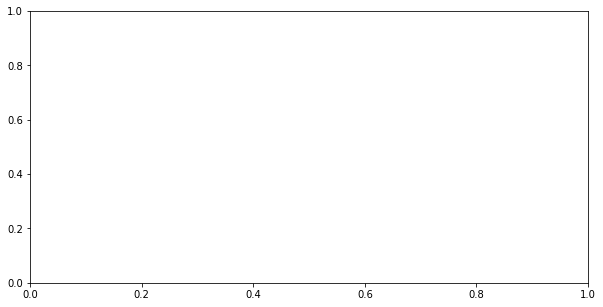

In [17]:
# Full Log Analysis

fig = plt.figure(figsize = (10, 5))
levels = list(set(df['Level']))
values = list(df['Level'])
level_values = [values.count(l) for l in levels]

# creating the bar plot
plt.bar(levels, level_values, color ='maroon',
        width = 0.4)

plt.xlabel("Log Levels")
plt.ylabel("Frequency")
plt.title("Log Level Analysis")
plt.show()

In [18]:
full_log = pd.DataFrame(data=level_values, index=levels)
full_log

,0
NaN,78
15-08-2021 19:53:53,1
15-09-2021 09:52:26,1
08-08-2021 13:34:01,1
10-07-2021 14:53:59,2
...,...
06-09-2021 17:16:37,1
19-08-2021 14:35:46,2
14-06-2021 08:32:51,1
11-08-2021 00:53:21,1


In [19]:
# Per Day Analysis

df['DateTime'] = pd.to_datetime(df['Date and Time'])
df['Date'] = pd.to_datetime(df['Date and Time']).dt.date
df.drop(columns=["Date and Time"])
date_df = df.groupby(['Date', 'Level']).count()[['Source']]
date_df.head(10)

ValueError: ('Unknown string format:', 'gupdate')